In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
# Load movie ratings dataset
ratings = pd.read_csv('ratings.csv')

In [5]:
# Convert user IDs and movie IDs to sequential integers
ratings['userId'] = pd.Categorical(ratings['userId']).codes
ratings['movieId'] = pd.Categorical(ratings['movieId']).codes

In [7]:
# Split data into training and validation sets
mask = np.random.rand(len(ratings)) < 0.8
train = ratings[mask]
val = ratings[~mask]

In [13]:

# Define model architecture
num_users = len(ratings['userId'].unique())
num_movies = len(ratings['movieId'].unique())

user_input = Input(shape=(1,))
user_embedding = Embedding(num_users, 32)(user_input)
user_embedding = Flatten()(user_embedding)

movie_input = Input(shape=(1,))
movie_embedding = Embedding(num_movies, 32)(movie_input)
movie_embedding = Flatten()(movie_embedding)

dot_product = Dot(axes=1)([user_embedding, movie_embedding])
output = Dense(1)(dot_product)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
with tf.device('CPU'):
    model.fit(x=[train['userId'], train['movieId']], y=train['rating'], batch_size=64, epochs=10, validation_data=([val['userId'], val['movieId']], val['rating']))

Train on 80663 samples, validate on 20173 samples
Epoch 1/10
80663/80663 [==============================] - 10s 123us/sample - loss: 7.2254 - val_loss: 1.8600
Epoch 2/10
80663/80663 [==============================] - 9s 115us/sample - loss: 1.2294 - val_loss: 1.1053
Epoch 3/10
80663/80663 [==============================] - 9s 114us/sample - loss: 0.8234 - val_loss: 0.9887
Epoch 4/10
80663/80663 [==============================] - 10s 118us/sample - loss: 0.6885 - val_loss: 0.9513
Epoch 5/10
80663/80663 [==============================] - 9s 114us/sample - loss: 0.5962 - val_loss: 0.9410
Epoch 6/10
80663/80663 [==============================] - 9s 114us/sample - loss: 0.5117 - val_loss: 0.9413
Epoch 7/10
80663/80663 [==============================] - 9s 116us/sample - loss: 0.4329 - val_loss: 0.9593
Epoch 8/10
80663/80663 [==============================] - 10s 118us/sample - loss: 0.3621 - val_loss: 0.9791
Epoch 9/10
80663/80663 [==============================] - 10s 121us/sample - loss: 

In [25]:
user_id = 23 #User ID
user_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
user_ratings = np.zeros(num_movies)
user_ratings[user_movies] = 1
movie_scores = model.predict([np.array([user_id]*num_movies), np.arange(num_movies)])
movie_ids = np.argsort(-movie_scores.flatten())[:10]
recommended_movies = pd.read_csv('movies.csv')
recommended_movies = recommended_movies[recommended_movies['movieId'].isin(movie_ids)]
pd.DataFrame(recommended_movies[['title', 'genres']])

,title,genres
153,Mighty Morphin Power Rangers: The Movie (1995),Action|Children
503,"Brady Bunch Movie, The (1995)",Comedy
1096,Fierce Creatures (1997),Comedy
1377,Almost Heroes (1998),Adventure|Comedy|Western
2615,Mr. Saturday Night (1992),Comedy|Drama
3122,Double Impact (1991),Action
5361,Being Julia (2004),Comedy|Drama


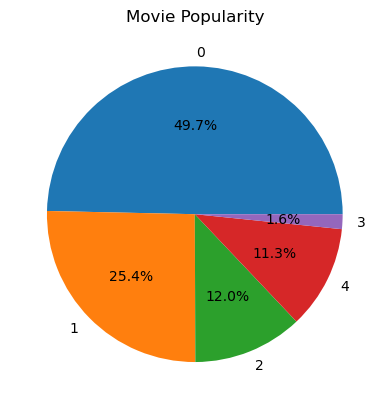

In [33]:
num_ratings = ratings.groupby('movieId').size().reset_index(name='num_ratings')[:5]
import matplotlib.pyplot as plt
# Sort movies by popularity (number of ratings)
num_ratings = num_ratings.sort_values('num_ratings', ascending=False)
# Create a pie chart of the number of ratings for each movie
plt.pie(num_ratings['num_ratings'], labels=num_ratings['movieId'], autopct='%1.1f%%')
plt.title('Movie Popularity')
plt.show()